In [1]:
import pandas as pd
import numpy as np
voice2 = pd.read_csv('Voice2.csv')

X_columns = ['Jitter (local, absolute)', 'Jitter (rap)', 'Jitter (ppq5)', 'Jitter (ddp)', 'Shimmer (local)',
             'Shimmer (local,dB)', 'Shimmer (apq3)', 'Shimmer (apq5)', 'Shimmer (apq11)', 'Shimmer (dda)']

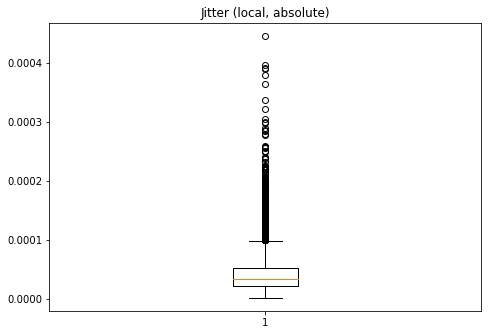

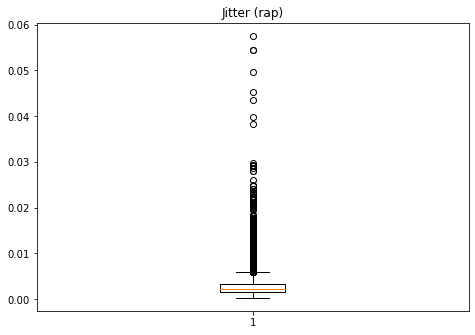

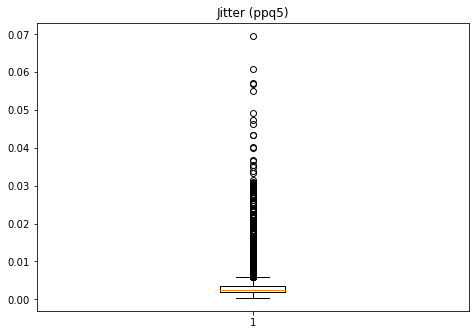

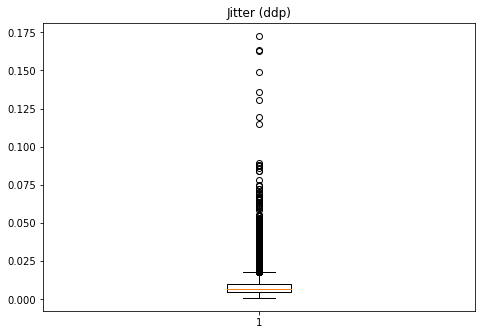

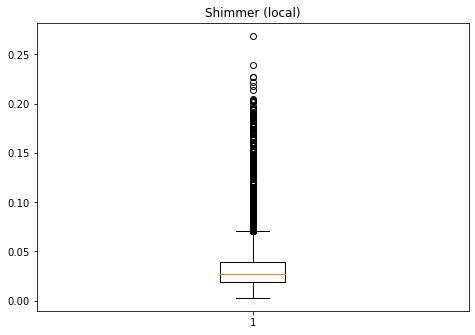

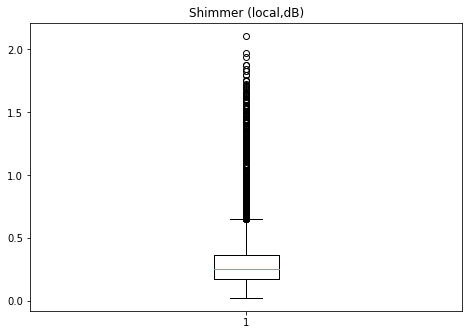

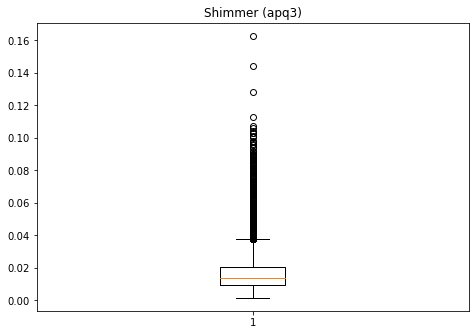

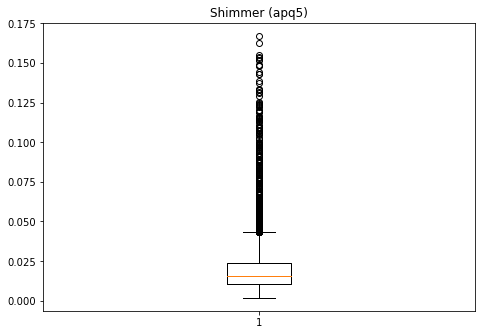

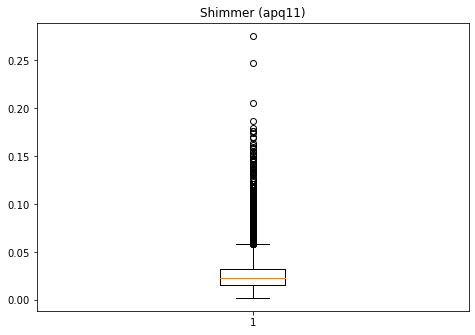

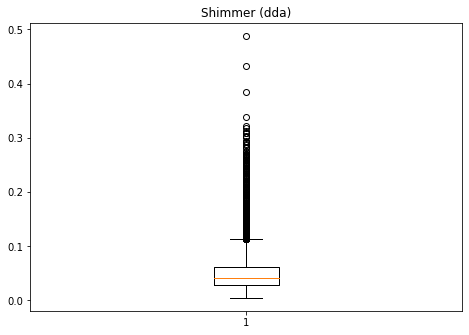

In [2]:
# Data visualization
import matplotlib.pyplot as plt

for col in X_columns:
    data = voice2[col]
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(data)
    plt.title(col)
    plt.show()

In [3]:
# Data preprocessing
X_standardized = np.empty(shape=[0, len(voice2)])
for col in X_columns:
    data = voice2[col]
    standardized_col = (data - data.mean()) / data.std()
    X_standardized = np.append(X_standardized, [standardized_col], axis=0)

X = np.swapaxes(X_standardized, 0, 1)
Y = voice2.iloc[:, 0]

# scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
# X = scaler.fit_transform(voice2[columns_to_normalize])
# Y = voice2.iloc[:, 0]
# #classification of UPDRS to clusters taken from 25% and 75% from the cluster

print(X.shape)
print(Y.shape)
print(X)
print(Y)

(5875, 10)
(5875,)
[[-0.28435508  0.32742464 -0.0286346  ... -0.42332047 -0.54341951
  -0.20968646]
 [-0.79293331 -0.55931048 -0.52172908 ... -0.93100374 -0.90016664
  -0.98528253]
 [-0.64841928 -0.40245119 -0.43597352 ... -0.81818523 -0.82311326
  -0.87674944]
 ...
 [-0.53725464 -0.4696766  -0.37701657 ... -0.335106   -0.43584499
  -0.26055347]
 [-0.65953574 -0.54650564 -0.47349158 ... -0.68676368 -0.72104255
  -0.77274906]
 [-0.63730281 -0.52409717 -0.43329366 ... -0.51633572 -0.63948605
  -0.58111639]]
0       3
1       3
2       3
3       3
4       3
       ..
5870    3
5871    3
5872    3
5873    3
5874    3
Name: levels, Length: 5875, dtype: int64


In [4]:
unique, counts = np.unique(Y, return_counts=True)
print(dict(zip(unique, counts)))

# Random Oversampling
import random

num_cats = X.shape[1]
max_count = max(counts)

df = pd.DataFrame(X)
df['label'] = Y.values

df_1 = df[df['label'] == 1]
df_2 = df[df['label'] == 2]
df_3 = df[df['label'] == 3]

random.seed(100)
sample_indexes_1 = random.choices(range(len(df_1)), k=max_count)
df_1_resampled = np.empty(shape=[0, num_cats])
for i in sample_indexes_1:
    df_1_resampled = np.append(df_1_resampled, [df_1.iloc[i, :num_cats]], axis=0)

sample_indexes_3 = random.choices(range(len(df_3)), k=max_count)
df_3_resampled = np.empty(shape=[0, num_cats])
for i in sample_indexes_3:
    df_3_resampled = np.append(df_3_resampled, [df_3.iloc[i, :num_cats]], axis=0)

X_resampled = np.empty(shape=[0, num_cats])
X_resampled = np.append(X_resampled, df_1_resampled, axis=0)
X_resampled = np.append(X_resampled, df_2.iloc[:, :num_cats], axis=0)
X_resampled = np.append(X_resampled, df_3_resampled, axis=0)

Y_labels = np.empty(shape=[0])
Y_labels = np.append(Y_labels, [0] * len(df_1_resampled), axis=0)
Y_labels = np.append(Y_labels, [1] * len(df_2), axis=0)
Y_labels = np.append(Y_labels, [2] * len(df_3_resampled), axis=0)

print(X_resampled.shape)
print(Y_labels.shape)
unique, counts = np.unique(Y_labels, return_counts=True)
print(dict(zip(unique, counts)))

{1: 267, 2: 2943, 3: 2665}
(8829, 10)
(8829,)
{0.0: 2943, 1.0: 2943, 2.0: 2943}


In [5]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

batch_size = 32

train_x, test_x, train_y, test_y = train_test_split(X_resampled, Y_labels, test_size = 0.2, random_state = 0)

print(train_y[:5])

train_x = torch.Tensor(train_x)
train_y = F.one_hot(torch.tensor(train_y).to(torch.int64), 3).to(torch.float32)
test_x = torch.Tensor(test_x)
test_y = F.one_hot(torch.tensor(test_y).to(torch.int64), 3).to(torch.float32)

print(train_y[:5])

train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

[0. 0. 2. 2. 2.]
tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn.functional as F

class MLPCWithDropout(nn.Module):
    def __init__(self, input_size):
        super(MLPCWithDropout, self).__init__()
        self.l1 = nn.Linear(input_size, 100)
        self.l2 = nn.Linear(100, 200)
        self.l3 = nn.Linear(200, 100)
        self.dropout3 = nn.Dropout(0.3)
        self.l5 = nn.Linear(100, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        output = self.l5(x)
        output = self.softmax(output)
        return output

In [12]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

minValidLoss = np.inf

input_size = X.shape[1]
model = MLPCWithDropout(input_size)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    epochTrainLoss = 0
    for data, labels in train_loader:
        (data, labels) = (data.to(device), labels.to(torch.float32).to(device))
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epochTrainLoss += loss

    print(f'Epoch {epoch} \t\t Training Loss: {epochTrainLoss.item()}')

print("Training complete!")

print(f'Saving Final Model')
torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict()
            }, 'voice_mlpc_10cols_121-4L_3D_resampling_CELoss_lr001_500epoch_model.pth')

Epoch 0 		 Training Loss: 224.48837280273438
Epoch 1 		 Training Loss: 217.9473114013672
Epoch 2 		 Training Loss: 214.43783569335938
Epoch 3 		 Training Loss: 212.70892333984375
Epoch 4 		 Training Loss: 211.2397003173828
Epoch 5 		 Training Loss: 209.6705780029297
Epoch 6 		 Training Loss: 208.80776977539062
Epoch 7 		 Training Loss: 208.1438446044922
Epoch 8 		 Training Loss: 207.33180236816406
Epoch 9 		 Training Loss: 206.5393524169922
Epoch 10 		 Training Loss: 205.46780395507812
Epoch 11 		 Training Loss: 204.51889038085938
Epoch 12 		 Training Loss: 203.92283630371094
Epoch 13 		 Training Loss: 202.4503936767578
Epoch 14 		 Training Loss: 202.37684631347656
Epoch 15 		 Training Loss: 200.9095001220703
Epoch 16 		 Training Loss: 200.4044952392578
Epoch 17 		 Training Loss: 199.59112548828125
Epoch 18 		 Training Loss: 199.5222930908203
Epoch 19 		 Training Loss: 199.22640991210938
Epoch 20 		 Training Loss: 197.9315948486328
Epoch 21 		 Training Loss: 197.37185668945312
Epoch 22

Epoch 179 		 Training Loss: 167.2652130126953
Epoch 180 		 Training Loss: 169.19427490234375
Epoch 181 		 Training Loss: 168.74293518066406
Epoch 182 		 Training Loss: 167.36044311523438
Epoch 183 		 Training Loss: 168.3494873046875
Epoch 184 		 Training Loss: 168.01365661621094
Epoch 185 		 Training Loss: 167.54310607910156
Epoch 186 		 Training Loss: 166.9171905517578
Epoch 187 		 Training Loss: 168.47232055664062
Epoch 188 		 Training Loss: 167.026611328125
Epoch 189 		 Training Loss: 166.7368621826172
Epoch 190 		 Training Loss: 166.63197326660156
Epoch 191 		 Training Loss: 167.0283966064453
Epoch 192 		 Training Loss: 167.26673889160156
Epoch 193 		 Training Loss: 166.52955627441406
Epoch 194 		 Training Loss: 166.78506469726562
Epoch 195 		 Training Loss: 167.18276977539062
Epoch 196 		 Training Loss: 166.01324462890625
Epoch 197 		 Training Loss: 169.10791015625
Epoch 198 		 Training Loss: 167.486572265625
Epoch 199 		 Training Loss: 168.34031677246094
Epoch 200 		 Training Los

Epoch 356 		 Training Loss: 162.04124450683594
Epoch 357 		 Training Loss: 160.0583038330078
Epoch 358 		 Training Loss: 160.72341918945312
Epoch 359 		 Training Loss: 158.55137634277344
Epoch 360 		 Training Loss: 160.94715881347656
Epoch 361 		 Training Loss: 160.3225860595703
Epoch 362 		 Training Loss: 159.4207305908203
Epoch 363 		 Training Loss: 160.85321044921875
Epoch 364 		 Training Loss: 159.59849548339844
Epoch 365 		 Training Loss: 160.1717987060547
Epoch 366 		 Training Loss: 159.40403747558594
Epoch 367 		 Training Loss: 159.9627227783203
Epoch 368 		 Training Loss: 160.0618896484375
Epoch 369 		 Training Loss: 161.24391174316406
Epoch 370 		 Training Loss: 159.83761596679688
Epoch 371 		 Training Loss: 159.84579467773438
Epoch 372 		 Training Loss: 160.5765380859375
Epoch 373 		 Training Loss: 160.88742065429688
Epoch 374 		 Training Loss: 159.74664306640625
Epoch 375 		 Training Loss: 158.8738250732422
Epoch 376 		 Training Loss: 159.48326110839844
Epoch 377 		 Training

Train Loss: 0.698297

Train Accuracy of     0: 83% (1948/2331)
Train Accuracy of     1: 84% (1990/2343)
Train Accuracy of     2: 85% (2033/2366)

Train Accuracy (Overall): 84% (5971/7040)


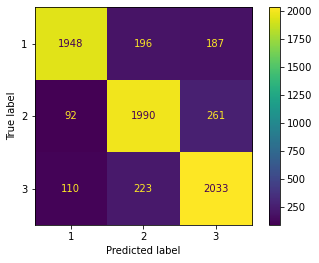

In [13]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
NUM_CLASSES = 3

train_loss = 0.0
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
actual = []
predicted = []

model.eval()

for i, (x, y) in enumerate(train_loader):
	(x, y) = (x.to(device), y.to(torch.float32).to(device))
	output = model(x)
	loss = criterion(output, y)
	train_loss += loss.item() * x.size(0)
	_, pred = torch.max(output, 1)   
	_, y = torch.max(y, 1)
	actual.extend(y)
	predicted.extend(pred)
	correct_tensor = pred.eq(y)
	correct = np.squeeze(correct_tensor)
	for i in range(len(y.data)):
		label = y.data[i]
		class_correct[label] += correct[i].item() 
		class_total[label] += 1

train_loss = train_loss/len(train_loader.dataset)
print('Train Loss: {:.6f}\n'.format(train_loss))

for i in range(NUM_CLASSES):
    print('Train Accuracy of %5s: %2d%% (%2d/%2d)' % (
        i, 100.0 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTrain Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3])

cm_display.plot()
plt.show()

# Accuracy = metrics.accuracy_score(actual, predicted)
# Precision = metrics.precision_score(actual, predicted)
# Sensitivity_recall = metrics.recall_score(actual, predicted)
# Specificity = metrics.recall_score(actual, predicted, pos_label=0)
# F1_score = metrics.f1_score(actual, predicted)

# #metrics:
# print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


Test Loss: 0.814111

Test Accuracy of     0: 81% (492/602)
Test Accuracy of     1: 62% (367/589)
Test Accuracy of     2: 74% (425/569)

Test Accuracy (Overall): 72% (1284/1760)


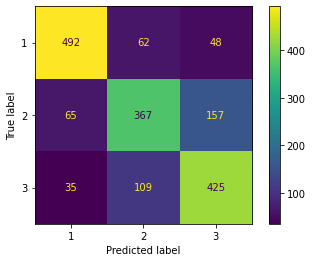

In [14]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

test_loss = 0.0
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
actual = []
predicted = []
model.eval()

for i, (x, y) in enumerate(test_loader):
	(x, y) = (x.to(device), y.to(torch.float32).to(device))
	output = model(x)
	loss = criterion(output, y)
	test_loss += loss.item() * x.size(0)
	_, pred = torch.max(output, 1)   
	_, y = torch.max(y, 1)
	actual.extend(y)
	predicted.extend(pred)
	correct_tensor = pred.eq(y)
	correct = np.squeeze(correct_tensor)
	for i in range(len(y.data)):
		label = y.data[i]
		class_correct[label] += correct[i].item() 
		class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(NUM_CLASSES):
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            i, 100.0 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3])

cm_display.plot()
plt.show()

# Accuracy = metrics.accuracy_score(actual, predicted)
# Precision = metrics.precision_score(actual, predicted)
# Sensitivity_recall = metrics.recall_score(actual, predicted)
# Specificity = metrics.recall_score(actual, predicted, pos_label=0)
# F1_score = metrics.f1_score(actual, predicted)

# #metrics:
# print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import pandas as pd
import numpy as np

class MLPCWithDropout(nn.Module):
    def __init__(self, input_size):
        super(MLPCWithDropout, self).__init__()
        self.l1 = nn.Linear(input_size, 100)
        self.l2 = nn.Linear(100, 200)
        self.l3 = nn.Linear(200, 100)
        self.dropout3 = nn.Dropout(0.3)
        self.l5 = nn.Linear(100, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        output = self.l5(x)
        output = self.softmax(output)
        return output

num_cats
model = MLPCWithDropout(num_cols)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

file_path = './voice_mlpc_10cols_121-4L_3D_resampling_CELoss_lr001_500epoch_model.pth'

checkpoint = torch.load(file_path)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [23]:
from sklearn import preprocessing
import numpy as np

voice_self_recorded = pd.read_csv('SoundData.csv')
X_recorded_cols = ['jitterAbs', 'jitterRap', 'jitterPPQ5', 'jitterDDP', 'shimmerLocal',
                   'shimmerLocalDB', 'shimmerAPQ3', 'shimmerAPQ5', 'shimmerAPQ11', 'shimmerDDA']

X2_standardized = np.empty(shape=[0, len(voice_self_recorded)])

for col in X_recorded_cols:
    data = voice_self_recorded[col]
    standardized_col = (data - data.mean()) / data.std()
    X2_standardized = np.append(X2_standardized, [standardized_col], axis=0)

X2_standardized = np.swapaxes(X2_standardized, 0, 1)

recorded_x = X2_standardized
recorded_y = voice_self_recorded['severity']
recorded_y = recorded_y.map({1:0, 2:1, 3:2})

print(recorded_x.shape)
print(recorded_y.shape)
print(recorded_x)
print(recorded_y)

(52, 10)
(52,)
[[-1.98211144e-01 -2.55678740e-01 -1.06051872e-01 -2.55678740e-01
   1.27932830e+00  3.12632316e-01  1.31968067e+00  1.65219776e+00
   1.03805295e+00  1.31968067e+00]
 [-1.19623636e-01 -1.74970006e-01 -2.92553671e-01 -1.74970006e-01
   1.46930299e+00  1.06995274e+00  1.30467421e+00  5.79695729e-01
   4.34802766e-01  1.30467421e+00]
 [ 7.11158592e-01  4.90958556e-01  6.70249355e-02  4.90958556e-01
   1.32787353e+00  6.05142321e-01  1.32070065e+00  1.56850625e+00
   9.93125755e-01  1.32070065e+00]
 [ 9.48984158e-01  7.90326647e-01  5.26483943e-01  7.90326647e-01
   1.05728784e+00 -2.74395066e-01  1.06744830e+00  1.35508519e+00
  -2.51177492e-01  1.06744830e+00]
 [-2.31644268e-02  1.44948139e-01  2.48970761e-01  1.44948139e-01
   3.64512329e-01 -2.92290096e-01  4.35365338e-01  4.21891010e-01
  -4.74602328e-01  4.35365338e-01]
 [ 1.05482301e+00  9.56277561e-01  8.16559089e-01  9.56277561e-01
   1.15419224e+00 -1.48559567e-01  1.21561385e+00  1.32723566e+00
   1.03158064e+00 

Name: severity, dtype: int64


In [24]:
batch_size = 32

print(recorded_y[:5])

recorded_x = torch.Tensor(recorded_x)
recorded_y = F.one_hot(torch.tensor(recorded_y).to(torch.int64), 3).to(torch.float32)

print(recorded_y[:5])

recorded_dataset = TensorDataset(recorded_x, recorded_y)

recorded_loader = DataLoader(recorded_dataset, batch_size=batch_size, drop_last=True)

0    1
1    1
2    1
3    1
4    1
Name: severity, dtype: int64
tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])


Recorded Loss: 0.814111

Recorded Accuracy of     0: 16% ( 1/ 6)
Recorded Accuracy of     1: 43% ( 7/16)
Recorded Accuracy of     2: 40% ( 4/10)
Recorded Accuracy (Overall): 37% (12/32)


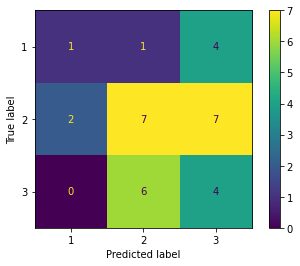

In [26]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

recorded_loss = 0.0
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
actual = []
predicted = []
model.eval()

for i, (x, y) in enumerate(recorded_loader):
	(x, y) = (x.to(device), y.to(torch.float32).to(device))
	output = model(x)
	loss = criterion(output, y)
	recorded_loss += loss.item() * x.size(0)
	_, pred = torch.max(output, 1)   
	_, y = torch.max(y, 1)
	actual.extend(y)
	predicted.extend(pred)
	correct_tensor = pred.eq(y)
	correct = np.squeeze(correct_tensor)
	for i in range(len(y.data)):
		label = y.data[i]
		class_correct[label] += correct[i].item() 
		class_total[label] += 1

recorded_loss = recorded_loss/len(recorded_loader.dataset)
print('Recorded Loss: {:.6f}\n'.format(test_loss))

for i in range(NUM_CLASSES):
    print('Recorded Accuracy of %5s: %2d%% (%2d/%2d)' % (
            i, 100.0 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('Recorded Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3])

cm_display.plot()
plt.show()